# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from IPython.display import display, Markdown, Image
from pprint import pformat
from dotenv import load_dotenv
import os
import types
import re
import json
from json import JSONDecodeError
import time
from tqdm.notebook import tqdm
from websockets.exceptions import ConnectionClosedError

from google import genai
from google.genai import types

# Setup

In [ ]:
# Configure on your own
load_dotenv(dotenv_path='../.env')
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')

In [3]:
async def handle_response(stream, print_process=False, display_output=False):
    """Stream output from the session.
    """
    all_responses = []
    text_lines = []

    async for msg in stream.receive():
        all_responses.append(msg)

        if text := msg.text:
            # When a text message is received.
            header = "### Text"
            # Display header if this is the first text chunk.
            if len(all_responses) < 2 or not all_responses[-2].text:
                if print_process:
                    display(Markdown(header))
                text_lines.append(header)

            if print_process:
                print(text, end='')
            text_lines.append(text)

        elif msg.server_content and msg.server_content.model_turn:
            # Handle model turn: display generated code, execution results, or inline images.
            for part in msg.server_content.model_turn.parts:
                if code := part.executable_code:
                    code_str = f"### Code\n```\n{code.code}\n```"
                    if print_process:
                        display(Markdown(code_str))
                elif result := part.code_execution_result:
                    result_str = (
                        f"### Result: `{result.outcome}`\n"
                        f"```\n{pformat(result.output)}\n```"
                    )
                    if print_process:
                        display(Markdown(result_str))
                elif img := part.inline_data:
                    if print_process:
                        display(Image(img.data))

    # When print_process is False, process the accumulated lines:
    if not print_process:
        combined_text = "\n".join(text_lines).strip()
        # Find the index of the last occurrence of the "### Text" header.
        marker = "### Text"
        last_marker_index = -1
        for i, line in enumerate(text_lines):
            if line.strip().startswith(marker):
                last_marker_index = i
        if last_marker_index != -1 and last_marker_index + 1 < len(text_lines):
            final_output = "\n".join(text_lines[last_marker_index + 1:]).strip()
        else:
            final_output = combined_text
        
        if display_output:
            display(Markdown(final_output))

    return all_responses, final_output

# Synthetic Data Generation

![Pricing](pricing.png "Pricing")

### We are going to use `gemini-2.0-flash-exp` which has Free Tier:
- **Requests Per Minute (RPM)**: 10
- **Tokens Per Minute (TPM)**: 1,000,000
- **Requests Per Day (RPD)**: 1000

In [4]:
system_instruction = """
You are a synthetic data generation assistant for structured contact center datasets used in Consumer Banking and Contact Center Operations at the Bank of the Philippine Islands (BPI).

Your job is to generate realistic **synthetic rows** of contact center cases. You must return data in **JSON format**, specifically as a **list of dictionaries**, where each dictionary represents one case. The fields and their constraints are as follows:

- `case_text_value_type`: One of the following:
    - "Single message"
    - "User-chatbot conversation"
    - "Multiple messages"
- `case_text`: Depending on the `case_text_value_type`:
    - If "Single message" → A single string in natural Taglish, Tagalog, or English.
    - If "User-chatbot conversation" → A list of alternating user/chatbot messages.
    - If "Multiple messages" → A list of user-only messages with a logical progression.
- `case_source`: One of ["Phone", "Email", "Branch", "Facebook"]
- `case_type`: One of ["Loans", "Credit Cards", "Deposits"]
- `case_transaction_type`: One of ["Complaint", "Inquiry", "Request"]
- `case_status`: One of ["New", "Assigned", "Closed", "Cancelled"]
- `case_priority_level`: One of ["High", "Medium", "Low"]
- `date_time_created`: ISO 8601 datetime string in the format `YYYY-MM-DDTHH:MM:SS+08:00`
- `date_time_closed`: Either an ISO 8601 datetime string later than `date_time_created` or null.
- `customer_tier`: One of ["Low", "Mid", "High"]

All generated content, especially `case_text`, must reflect natural Filipino communication styles (Tagalog, Taglish, English) and simulate actual customer support situations realistically. However, focus more on Tagalog and Taglish, as these are the most common languages used in the Philippines.

Return only the list of JSON objects. Below is an example output:

[
  {
    "case_text_value_type": "Single message",
    "case_text": "Hindi ko ma-open ang statements ko sa BPI online, anong gagawin ko?",
    "case_source": "Email",
    "case_type": "Credit Cards",
    "case_transaction_type": "Inquiry",
    "case_status": "Assigned",
    "case_priority_level": "High",
    "date_time_created": "2025-05-13T15:45:00+08:00",
    "date_time_closed": null,
    "customer_tier": "High"
  },
  {
    "case_text_value_type": "Single message",
    "case_text": "BPI app ko keeps logging me out tuwing magta-apply ako ng loan.",
    "case_source": "Facebook",
    "case_type": "Loans",
    "case_transaction_type": "Complaint",
    "case_status": "New",
    "case_priority_level": "High",
    "date_time_created": "2025-05-14T10:00:00+08:00",
    "date_time_closed": null,
    "customer_tier": "Low"
  },
  {
    "case_text_value_type": "User-chatbot conversation",
    "case_text": [
      "User: Hi PO, kailangan ko po ng tulong maglink ng account sa GCASH.",
      "Chatbot: Sure! Please provide your registered mobile number.",
      "User: 09171234567 po.",
      "Chatbot: Got it. Sending OTP now. Please enter the 6-digit code you received."
    ],
    "case_source": "Phone",
    "case_type": "Deposits",
    "case_transaction_type": "Request",
    "case_status": "Closed",
    "case_priority_level": "Low",
    "date_time_created": "2025-05-12T11:20:00+08:00",
    "date_time_closed": "2025-05-12T11:30:00+08:00",
    "customer_tier": "Mid"
  },
  {
    "case_text_value_type": "Multiple messages",
    "case_text": [
      "Magkano po ang na-rebate ko sa credit card statement ko ngayong buwan?",
      "Rebate should be sa Amore Cashback promo, 1200 po yata.",
      "Please apply the rebate to my credit card balance. Thanks!"
    ],
    "case_source": "Facebook",
    "case_type": "Credit Cards",
    "case_transaction_type": "Request",
    "case_status": "Closed",
    "case_priority_level": "Medium",
    "date_time_created": "2025-05-10T09:00:00+08:00",
    "date_time_closed": "2025-05-11T14:00:00+08:00",
    "customer_tier": "High"
  }
]
"""


In [ ]:
async def generate_synthetic_data(
    model,
    system_instruction,
    api_key,
    rows: int = 30,
    display_output: bool = False,
    save_df: bool = False,
    verbose: bool = True
):
    """
    Async, chunked, rate-limited synthetic data generator with
    JSON-parse retries and live-session auto-restart logic.
    """
    chunk_size = 5 # 5 rows per prompt
    max_requests_per_minute = 10 # Gemini limit of 10 requests per minute
    iterations = (rows + chunk_size - 1) // chunk_size

    # master DataFrame schema
    df = pd.DataFrame({
        'case_text_value_type':    pd.Series(dtype='category'),
        'case_text':               pd.Series(dtype='object'),
        'case_source':             pd.Series(dtype='category'),
        'case_type':               pd.Series(dtype='category'),
        'case_transaction_type':   pd.Series(dtype='category'),
        'case_status':             pd.Series(dtype='category'),
        'case_priority_level':     pd.Series(dtype='category'),
        'date_time_created':       pd.Series(dtype='datetime64[ns]'),
        'date_time_closed':        pd.Series(dtype='datetime64[ns]'),
        'customer_tier':           pd.Series(dtype='category'),
    })

    total_chunks_done = 0
    session_restarts = 0
    max_session_restarts = 10
    max_parse_attempts = 4

    # outer loop: restart entire live session on ConnectionClosedError
    while total_chunks_done < iterations and session_restarts <= max_session_restarts:
        try:
            # (re)create client & session
            live_client = genai.Client(
                api_key=api_key,
                http_options=types.HttpOptions(api_version='v1alpha')
            )
            config = {
                "response_modalities": ["TEXT"],
                "system_instruction": system_instruction,
                "tools": [{"code_execution": {}}]
            }
            window_start = time.monotonic()
            requests_made = 0
            session_chunk_count = 0

            async with live_client.aio.live.connect(
                model=model,
                config=config
            ) as session:

                while total_chunks_done < iterations:
                    now = time.monotonic()
                    elapsed = now - window_start

                    # rate‐limit window reset
                    if elapsed >= 60:
                        window_start = now
                        requests_made = 0
                        if verbose:
                            tqdm.write("[rate-limit] Window reset.")

                    # enforce max_requests_per_minute
                    if requests_made >= max_requests_per_minute:
                        sleep_time = 60 - elapsed
                        if sleep_time > 0:
                            if verbose:
                                tqdm.write(f"[rate-limit] Sleeping {sleep_time:.1f}s…")
                            time.sleep(sleep_time)
                        window_start = time.monotonic()
                        requests_made = 0
                        if verbose:
                            tqdm.write("[rate-limit] Resuming.")

                    # choose prompt text
                    if session_chunk_count == 0:
                        prompt = "Generate 5 unique rows"
                        prompt_display = "Generate 5 unique rows"
                    else:
                        prompt = """Generate exactly 5 unique rows as a pure JSON array of objects. Each object must have these fields with their allowed values:

                        - "case_text_value_type": one of ["Single message", "User-chatbot conversation", "Multiple messages"]
                        - "case_text": 
                            • If "Single message": a single string in natural Taglish, Tagalog, or English  
                            • If "User-chatbot conversation": a JSON list of alternating user/chatbot messages  
                            • If "Multiple messages": a JSON list of user-only messages with logical progression
                        - "case_source": one of ["Phone", "Email", "Branch", "Facebook"]
                        - "case_type": one of ["Loans", "Credit Cards", "Deposits"]
                        - "case_transaction_type": one of ["Complaint", "Inquiry", "Request"]
                        - "case_status": one of ["New", "Assigned", "Closed", "Cancelled"]
                        - "case_priority_level": one of ["High", "Medium", "Low"]
                        - "date_time_created": ISO 8601 string ("YYYY-MM-DDTHH:MM:SS+08:00")
                        - "date_time_closed": ISO 8601 string later than date_time_created or null
                        - "customer_tier": one of ["Low", "Mid", "High"]"""
                        prompt_display = "Generate exactly 5 unique rows as a pure JSON array of objects"

                    fail_prompt = """The last output was invalid. Regenerate exactly 5 more unique rows as a pure JSON array of objects. Each object must have these fields with their allowed values:

                        - "case_text_value_type": one of ["Single message", "User-chatbot conversation", "Multiple messages"]
                        - "case_text": 
                            • If "Single message": a single string in natural Taglish, Tagalog, or English  
                            • If "User-chatbot conversation": a JSON list of alternating user/chatbot messages  
                            • If "Multiple messages": a JSON list of user-only messages with logical progression
                        - "case_source": one of ["Phone", "Email", "Branch", "Facebook"]
                        - "case_type": one of ["Loans", "Credit Cards", "Deposits"]
                        - "case_transaction_type": one of ["Complaint", "Inquiry", "Request"]
                        - "case_status": one of ["New", "Assigned", "Closed", "Cancelled"]
                        - "case_priority_level": one of ["High", "Medium", "Low"]
                        - "date_time_created": ISO 8601 string ("YYYY-MM-DDTHH:MM:SS+08:00")
                        - "date_time_closed": ISO 8601 string later than date_time_created or null
                        - "customer_tier": one of ["Low", "Mid", "High"]"""
                    fail_prompt_display = "The last output was invalid. Regenerate exactly 5 more unique rows as a pure JSON array of objects"

                    if verbose:
                        tqdm.write(f"[req {total_chunks_done+1}/{iterations}] Prompt: {prompt_display!r}")

                    await session.send(input=prompt, end_of_turn=True)
                    _, output = await handle_response(
                        stream=session,
                        print_process=False,
                        display_output=display_output
                    )

                    # strip markdown fences
                    json_str = output.strip()
                    if json_str.startswith("```"):
                        lines = json_str.splitlines()
                        json_str = "\n".join(lines[1:-1])

                    # try JSON parsing with retries
                    records = None
                    parse_attempts = 0
                    while records is None and parse_attempts < max_parse_attempts:
                        try:
                            records = json.loads(json_str)
                        except JSONDecodeError:
                            parse_attempts += 1
                            tqdm.write(f"[parse-error] JSON decode failed ({parse_attempts}/{max_parse_attempts}), retrying…")

                            if verbose:
                                tqdm.write(f"[req {total_chunks_done+1}/{iterations}] Prompt: {fail_prompt_display!r}")

                            await session.send(input=fail_prompt, end_of_turn=True)
                            _, output = await handle_response(
                                stream=session,
                                print_process=False,
                                display_output=display_output
                            )
                            json_str = output.strip()
                            if json_str.startswith("```"):
                                lines = json_str.splitlines()
                                json_str = "\n".join(lines[1:-1])

                    if records is None:
                        raise RuntimeError("JSON parsing failed after 3 attempts")

                    # build DataFrame chunk
                    new_df = pd.DataFrame(records)
                    for c in [
                        'case_text_value_type','case_source','case_type',
                        'case_transaction_type','case_status',
                        'case_priority_level','customer_tier'
                    ]:
                        new_df[c] = new_df[c].astype('category')

                    new_df['date_time_created'] = pd.to_datetime(new_df['date_time_created'])
                    new_df['date_time_closed']  = pd.to_datetime(new_df['date_time_closed'])

                    # append to master DataFrame
                    if df.empty:
                        df = new_df.copy()
                    else:
                        df = pd.concat([df, new_df], ignore_index=True)
                        
                    total_chunks_done += 1
                    session_chunk_count += 1
                    requests_made += 1

            # if we exit normally, break out
            break

        except ConnectionClosedError as e:
            session_restarts += 1
            tqdm.write(f"[connection-error] Connection closed (code={e.code}), restarting session {session_restarts}/{max_session_restarts}…")
            # small backoff before retry
            time.sleep(1)
            continue

        except Exception as e:
            # unrecoverable – save & return current df
            tqdm.write(f"[error] {type(e).__name__}: {e}. Saving partial results and returning.")
            df.insert(0, 'case_id', [f"C{idx+1:05d}" for idx in df.index])
            if save_df:
                df.to_csv('synthetic_data.csv', index=False)
                if verbose:
                    print("[save] Wrote synthetic_data.csv")
            return df

    # final wrap-up: assign IDs and save if needed
    df.insert(0, 'case_id', [f"C{idx+1:05d}" for idx in df.index])
    if save_df:
        df.to_csv('synthetic_data.csv', index=False)
        if verbose:
            print("[save] Wrote synthetic_data.csv")
    return df

In [6]:
df = await generate_synthetic_data(
    model='gemini-2.0-flash-exp',
    system_instruction=system_instruction,
    api_key=GOOGLE_API_KEY,
    rows=2000,
    display_output=False,
    save_df=True,
    verbose=True
)

C:\Users\dariu\AppData\Local\Temp\ipykernel_32596\2404261243.py:54: ExperimentalWarning: The live API is experimental and may change in future versions.
  async with live_client.aio.live.connect(


[req 1/400] Prompt: 'Generate 5 unique rows'
[req 2/400] Prompt: 'Generate exactly 5 unique rows as a pure JSON array of objects'
[req 3/400] Prompt: 'Generate exactly 5 unique rows as a pure JSON array of objects'
[req 4/400] Prompt: 'Generate exactly 5 unique rows as a pure JSON array of objects'
[req 5/400] Prompt: 'Generate exactly 5 unique rows as a pure JSON array of objects'
[req 6/400] Prompt: 'Generate exactly 5 unique rows as a pure JSON array of objects'
[req 7/400] Prompt: 'Generate exactly 5 unique rows as a pure JSON array of objects'
[req 8/400] Prompt: 'Generate exactly 5 unique rows as a pure JSON array of objects'
[req 9/400] Prompt: 'Generate exactly 5 unique rows as a pure JSON array of objects'
[req 10/400] Prompt: 'Generate exactly 5 unique rows as a pure JSON array of objects'
[rate-limit] Sleeping 21.5s…
[rate-limit] Resuming.
[req 11/400] Prompt: 'Generate exactly 5 unique rows as a pure JSON array of objects'
[req 12/400] Prompt: 'Generate exactly 5 unique row

# Data Cleaning and EDA

In [29]:
df.head()

,case_id,case_text_value_type,case_text,case_source,case_type,case_transaction_type,case_status,case_priority_level,date_time_created,date_time_closed,customer_tier,case_text_type
0,C00001,Single message,"Hello, BPI! Hindi ko po makita yung bagong cre...",Email,Credit Cards,Inquiry,New,Medium,2024-01-25 08:30:00+08:00,NaT,Mid,NaN
1,C00002,User-chatbot conversation,"[User: I want to apply for a personal loan., C...",Phone,Loans,Request,Assigned,High,2024-01-26 14:15:00+08:00,NaT,High,NaN
2,C00003,Multiple messages,[Bakit po ang tagal bago mag-reflect yung tran...,Facebook,Deposits,Complaint,Assigned,High,2024-01-27 09:00:00+08:00,NaT,Low,NaN
3,C00004,Single message,Good day! I would like to inquire about the in...,Branch,Deposits,Inquiry,Closed,Low,2024-01-28 11:45:00+08:00,2024-01-28 12:00:00+08:00,Mid,NaN
4,C00005,Single message,Di ko po ma-access yung BPI mobile app ko. Lag...,Phone,Deposits,Complaint,New,Medium,2024-01-29 16:20:00+08:00,NaT,Low,NaN


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype                    
---  ------                 --------------  -----                    
 0   case_id                2000 non-null   object                   
 1   case_text_value_type   1999 non-null   object                   
 2   case_text              2000 non-null   object                   
 3   case_source            2000 non-null   object                   
 4   case_type              2000 non-null   object                   
 5   case_transaction_type  2000 non-null   object                   
 6   case_status            2000 non-null   object                   
 7   case_priority_level    2000 non-null   object                   
 8   date_time_created      2000 non-null   datetime64[ns, UTC+08:00]
 9   date_time_closed       359 non-null    object                   
 10  customer_tier          2000 non-null   object   

### Case Text Value Type

In [31]:
df[df['case_text_value_type'].isnull()]

,case_id,case_text_value_type,case_text,case_source,case_type,case_transaction_type,case_status,case_priority_level,date_time_created,date_time_closed,customer_tier,case_text_type
1476,C01477,NaN,[User: Why is my bpi credit card declined when...,Phone,Credit Cards,Complaint,Assigned,High,2026-02-16 14:30:00+08:00,NaT,Mid,User-chatbot conversation


In [32]:
df['case_text_value_type'] = df['case_text_value_type'].fillna('Multiple messages')

### Case Source

In [33]:
df['case_source'].value_counts()

case_source
Phone           727
Email           483
Branch          398
Facebook        389
Credit Cards      2
Loans             1
Name: count, dtype: int64

In [34]:
df['case_source'] = df['case_source'].replace(['Credit Cards', 'Loans'], 'Branch')

In [35]:
df['case_source'] = df['case_source'].where(df['case_source'].isin(['Phone', 'Email', 'Branch', 'Facebook']), 'Branch')
df['case_source'].value_counts()

case_source
Phone       727
Email       483
Branch      401
Facebook    389
Name: count, dtype: int64

### Case Status

In [36]:
df['case_status'].value_counts()

case_status
New          1222
Assigned      418
Closed        355
Cancelled       4
High            1
Name: count, dtype: int64

In [37]:
df[df['case_status'] == 'High']

,case_id,case_text_value_type,case_text,case_source,case_type,case_transaction_type,case_status,case_priority_level,date_time_created,date_time_closed,customer_tier,case_text_type
67,C00068,Multiple messages,"[Bakit po hindi ako makapag-withdraw sa ATM?, ...",Facebook,Deposits,Complaint,High,High,2025-02-05 15:45:00+08:00,NaT,Low,NaN


In [38]:
valid_status = ['New', 'Assigned', 'Closed', 'Cancelled']
mode_status = df.loc[df['case_status'].isin(valid_status), 'case_status'].mode()[0]
df['case_status'] = df['case_status'].where(df['case_status'].isin(valid_status), mode_status)

df['case_status'].value_counts()

case_status
New          1223
Assigned      418
Closed        355
Cancelled       4
Name: count, dtype: int64

### Exploratory Data Analysis

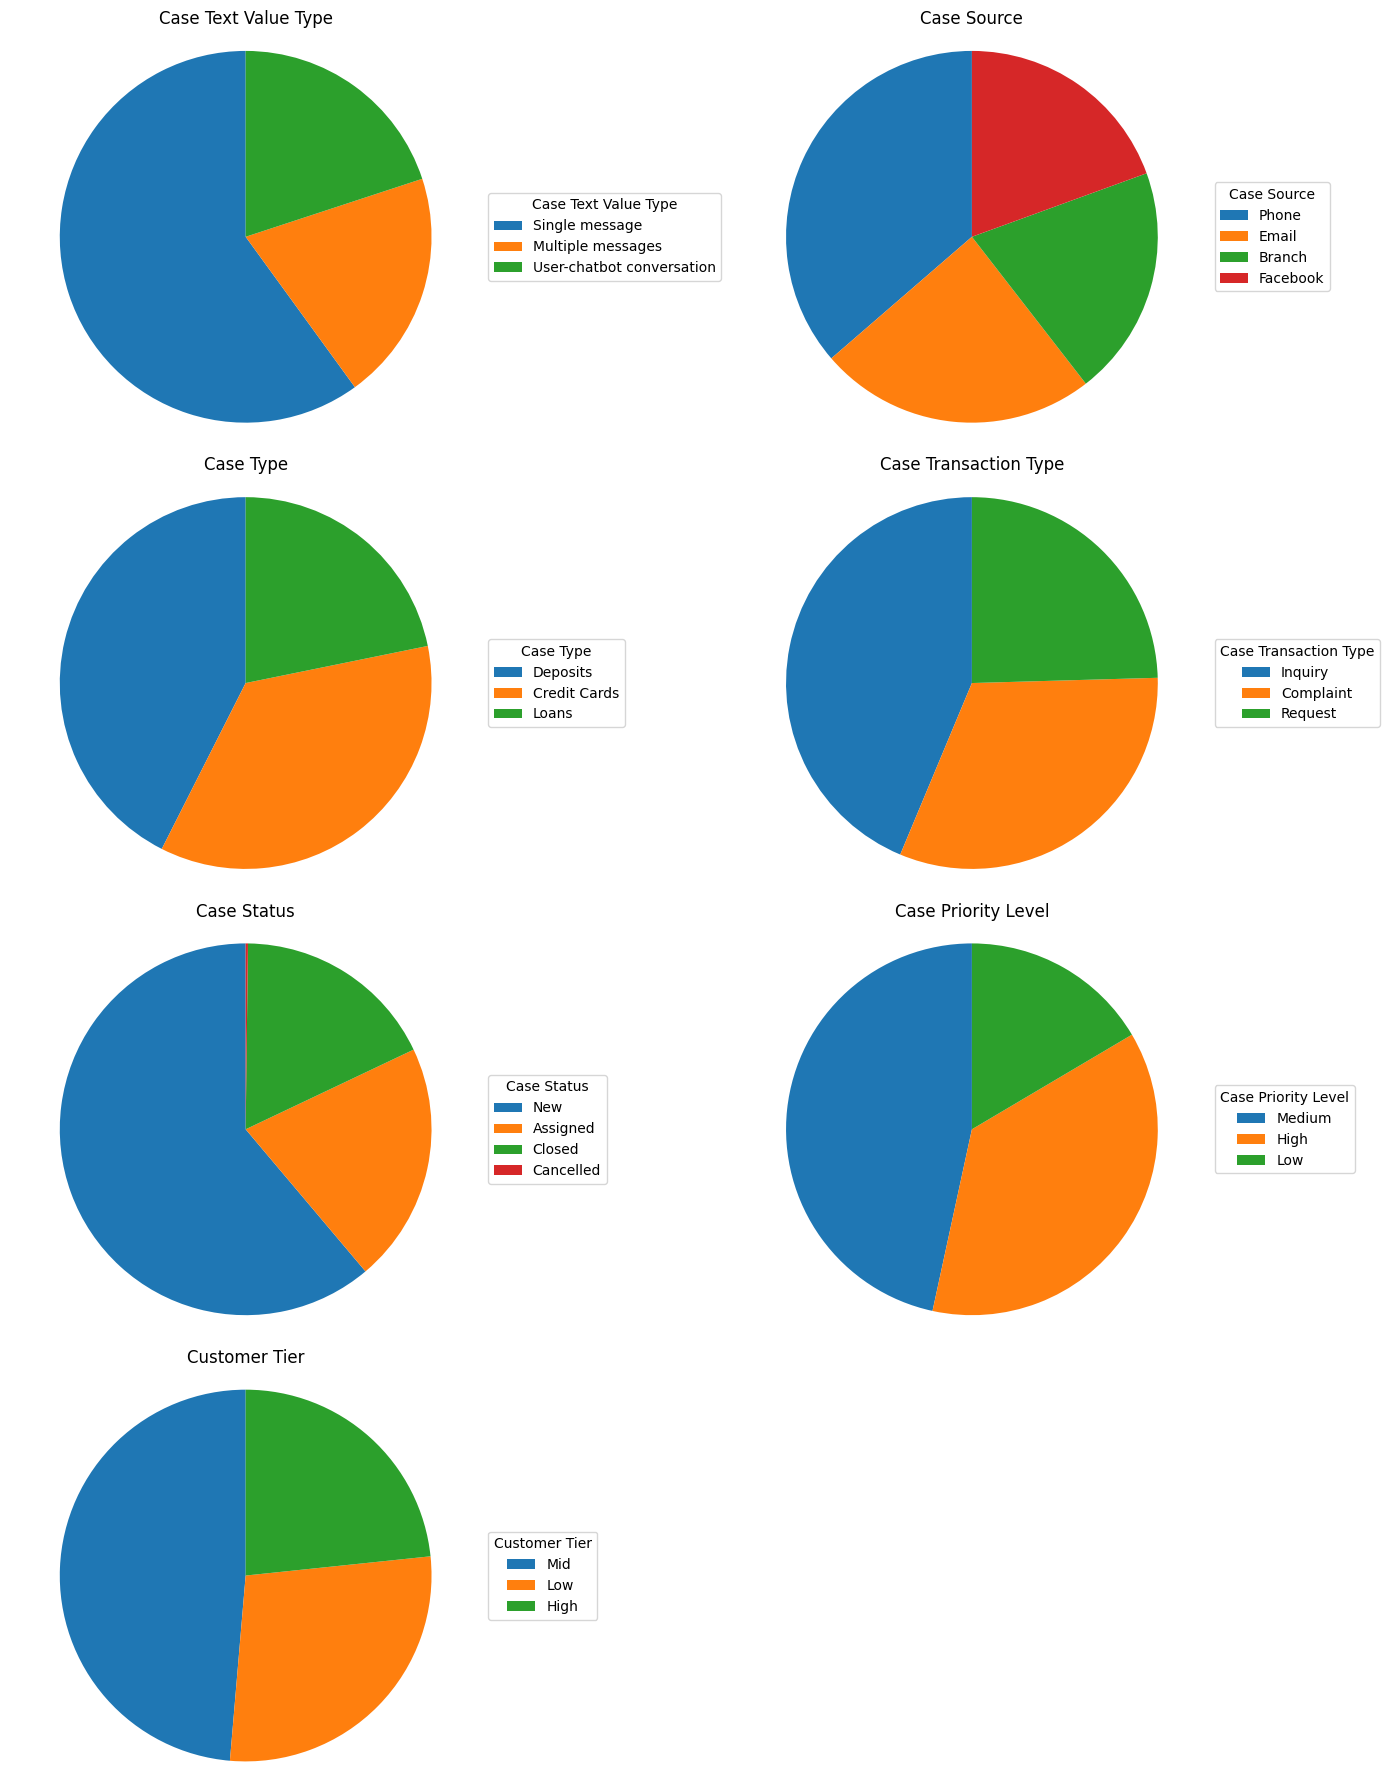

In [44]:
cols = [
    'case_text_value_type',
    'case_source',
    'case_type',
    'case_transaction_type',
    'case_status',
    'case_priority_level',
    'customer_tier'
]

fig, axes = plt.subplots(4, 2, figsize=(14, 18))
axes = axes.flatten()

for i, col in enumerate(cols):
    counts = df[col].value_counts()
    wedges, texts, autotexts = axes[i].pie(
        counts,
        labels=counts.index,
        autopct='%1.1f%%',
        startangle=90
    )
    axes[i].set_title(col.replace("_", " ").title())
    axes[i].axis('equal')    # keeps the pie circular

    # use a legend:
    for txt in texts + autotexts:
        txt.set_visible(False)
    axes[i].legend(
        wedges,
        counts.index,
        title=col.replace("_", " ").title(),
        loc='center left',
        bbox_to_anchor=(1, 0, 0.5, 1)
    )

# hide last empty subplot
if len(cols) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

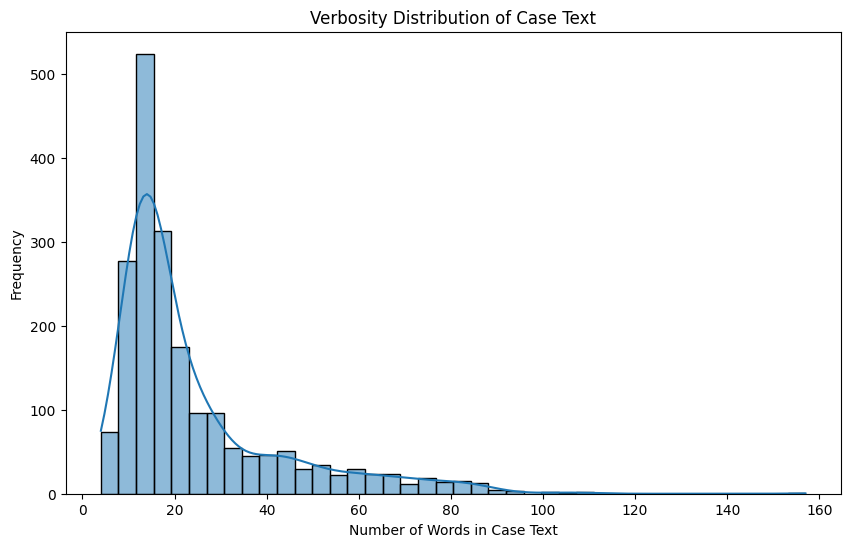

In [40]:
# Prepare a "verbosity" metric: number of words in each case_text (joining lists with ' | ')
def get_verbosity(text):
    if isinstance(text, list):
        joined = ' | '.join(text)
    else:
        joined = str(text)
    return len(joined.split())

verbosity = df['case_text'].apply(get_verbosity)

plt.figure(figsize=(10, 6))
sns.histplot(verbosity, bins=40, kde=True)
plt.xlabel('Number of Words in Case Text')
plt.ylabel('Frequency')
plt.title('Verbosity Distribution of Case Text')
plt.show()

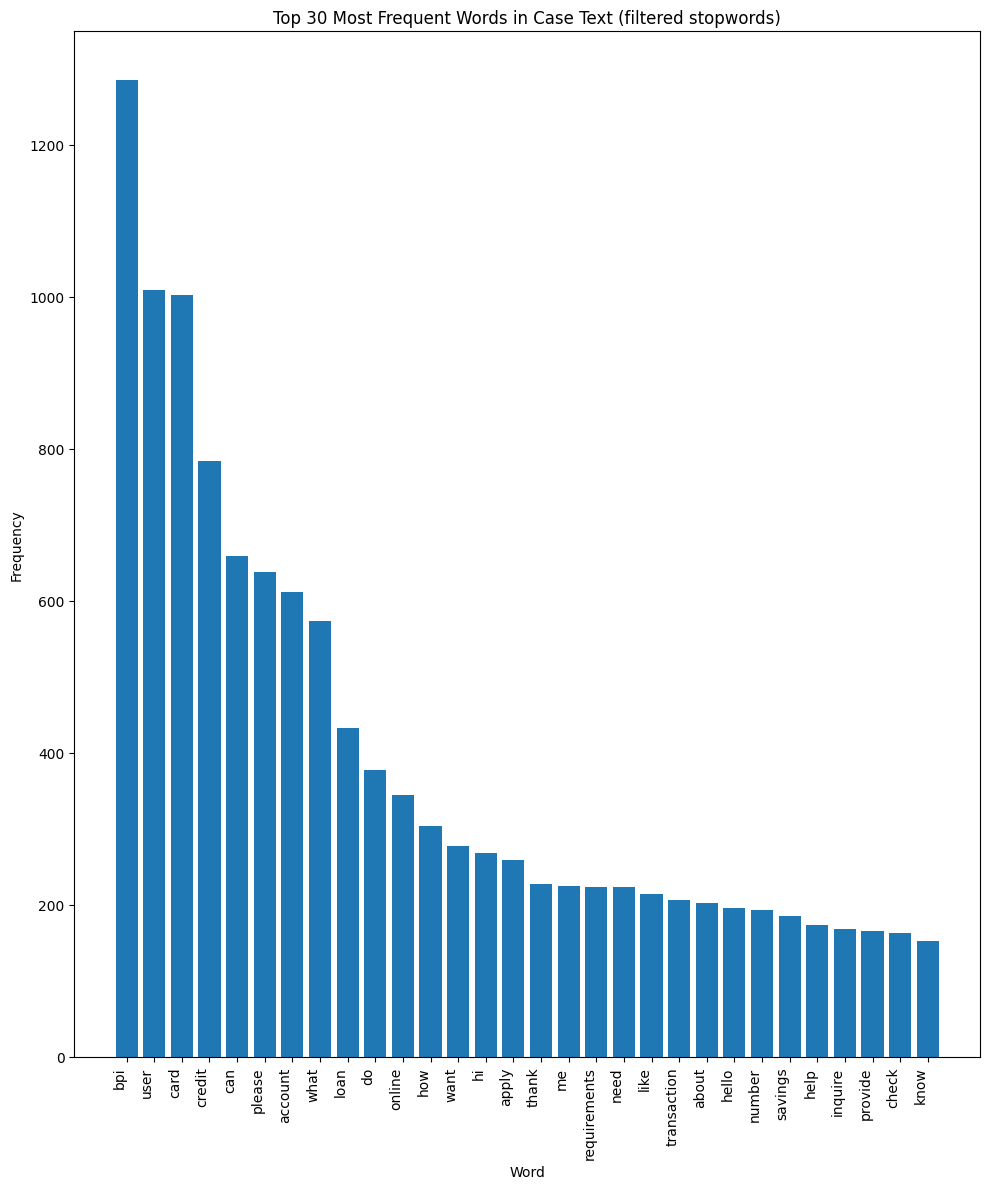

In [42]:
# Join all case_text entries into a single string (joining lists if needed)
all_text = df['case_text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x)).str.cat(sep=' ')

# Tokenize: split on whitespace, remove punctuation, lowercase
words = re.findall(r'\b\w+\b', all_text.lower())

# Define common stopwords to exclude
stopwords = {
    'i', 'and', 'to', 'the', 'a', 'is', 'in', 'of', 'for', 'on', 'it', 'you', 
    'that', 'this', 'as', 'are', 'was', 'but', 'be', 'at', 'or', 'not', 'my',
    'with', 'have', 'has', 'had', 'from', 'they', 'he', 'she', 'we', 'their',
    'them', 'our', 'us', 'your', 'yours', 'its', 'an', 'by', 'so', 'if', 'then', 
    
    'chatbot', 'm', 's', 'ng', 'sa', 'ko', 'po', 't'
}

# Filter out stopwords
filtered_words = [w for w in words if w not in stopwords]

# Count word frequencies
word_counts = Counter(filtered_words)
top10 = word_counts.most_common(30)

# Prepare for plotting
words, counts = zip(*top10)

plt.figure(figsize=(10, 12))
plt.bar(words, counts)
plt.xticks(rotation=90, ha='right')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 30 Most Frequent Words in Case Text (filtered stopwords)')
plt.tight_layout()
plt.show()

### Save Cleaned Synthetic Data

In [45]:
df.to_csv('synthetic_data.csv', index=False)